### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import seaborn as sns

In [243]:
data=pd.read_csv('/content/drive/MyDrive/part-088.csv')

In [3]:
data.head()

,host,process,timestamp,isAnomaly,"Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))","Active connections : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionsTotalCount))",Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used)),"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)","Reserve request activity : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Stuck threads : (MXBean(com.bea:Name=DataRetirementWorkManager,Type=WorkManagerRuntime).StuckThreadCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))","Connection delay : (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Active connections : (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))","Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)",Rel. heap committed : ((MXBean(java.lang:type=Memory).HeapMemoryUsage.committed / MXBean(java.lang:type=Memory).HeapMemoryUsage.max)),"Active connections : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))",Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"DB connection started : (incld/dx (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))","Prepared statement cache hit rate : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Connection delay : (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Reserve request activity : (incld/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ReserveRequestCount))",Rel. Swap Usage : ((\Swap\used / \Swap\total)),"Stuck threads : (MXBean(com.bea:Name=ClusterMessaging,Type=WorkManagerRuntime).StuckThreadCount)","Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))","Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))","Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))","Stuck threads : (MXBean(com.bea:ApplicationRuntime=batchModules2,Name=default,Type=WorkManagerRuntime).StuckThreadCount)","Active connections : (MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Reserve request activity : (incld/dx (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Memory space usage : ((MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.committed / M

In [ ]:
#dimensions
data.shape

(38797, 235)

In [244]:
#removing rows with constant values

def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]
data=data.drop(columns=remove_constant_value_features(data))

In [ ]:
#null values
np.sum(np.sum(data.isna()))

0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


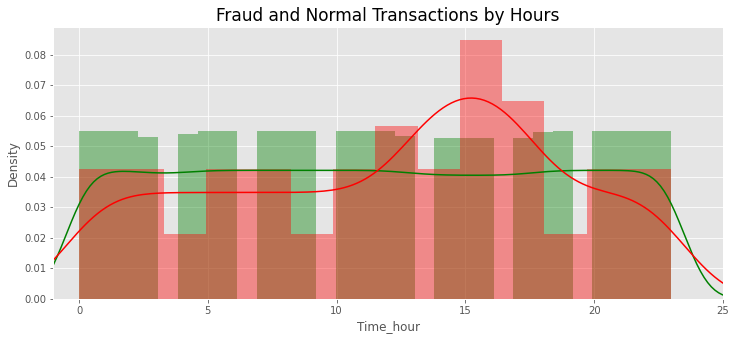

In [154]:
#anomalies by hour
timedelta = pd.to_datetime(data['timestamp'])
data['Time_hour'] = (timedelta.dt.hour).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(data[data['isAnomaly'] == 0]["Time_hour"], color='g')
sns.distplot(data[data['isAnomaly'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Peak in fraud transcations at 3 pm

In [245]:
target=data['isAnomaly']
data=data.drop(columns=['timestamp']) #dropping right now but will require in a later section

In [ ]:
data['isAnomaly'].value_counts() #number of anomalies

False    37074
True      1723
Name: isAnomaly, dtype: int64

In [246]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(data,target);

not_imp=[]
for name, importance in zip(data.columns, rnd_clf.feature_importances_):
  if importance > 0.020 :
    not_imp.append(name)

data=data.drop(columns=not_imp)

In [192]:
list_of_tuples = list(zip(data.columns, rnd_clf.feature_importances_))
pd.DataFrame(list_of_tuples, columns = ['Columns', 'Importance']).sort_values(by='Importance', ascending=False)

,Columns,Importance
18,Available db connection activity : (d/dx (MXBe...,0.195783
0,Memory space usage : ((MXBean(java.lang:name=C...,0.166857
25,Prepared statement cache hit rate : ((MXBean(c...,0.085707
13,Rel. nonHeap committed : ((MXBean(java.lang:ty...,0.052861
28,Available db connection activity : (d/dx (MXBe...,0.038794
...,...,...
12,Rel. unavailable connections : ((MXBean(com.be...,0.000000
45,Memory space activity : (d/dx ((MXBean(java.la...,0.000000
43,Rel. unavailable connections : ((MXBean(com.be...,0.000000
1,Heap usage activity : (d/dx (MXBean(java.lang:...,0.000000


In [247]:
#Dropping high correlated columns
cor_matrix=data.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data=data.drop(columns=to_drop)

### Auto Outlier Detection Algorithms

In [15]:
factor=1723/38797 #number of fraud cases

In [16]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(data), 
                                       contamination=factor,random_state=0, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=factor),
    "Support Vector Machine":OneClassSVM(kernel='linear', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1),
    "Elliptic Envelope":EllipticEnvelope(contamination=factor)
   
}

In [138]:
from sklearn.metrics import classification_report,accuracy_score
n_outliers = 1723
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(data)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(data)
        y_pred = clf.predict(data)
    else:    
        clf.fit(data)
        scores_prediction = clf.decision_function(data)
        y_pred = clf.predict(data)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != target).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(target,y_pred))
    print(confusion_matrix(target, y_pred))

Isolation Forest: 3062
Accuracy Score :
0.921076371884424
[[35543  1531]
 [ 1531   192]]
Local Outlier Factor: 3122
Accuracy Score :
0.9195298605562285
[[35513  1561]
 [ 1561   162]]
Support Vector Machine: 3662
Accuracy Score :
0.9056112586024693
[[35135  1939]
 [ 1723     0]]
Elliptic Envelope: 2778
Accuracy Score :
0.9283965255045493
[[35685  1389]
 [ 1389   334]]


### Auto-Encoders

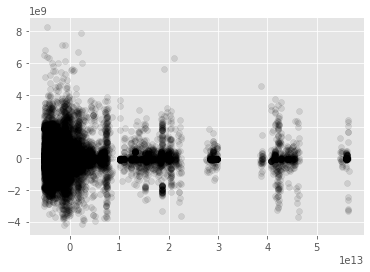

In [67]:
#Looking for clusters
from sklearn.decomposition import PCA
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(data)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], alpha=.1, color='black')

In [82]:
import tensorflow as tf
import random as rn
# manual parameters
RANDOM_SEED = 42
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [84]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

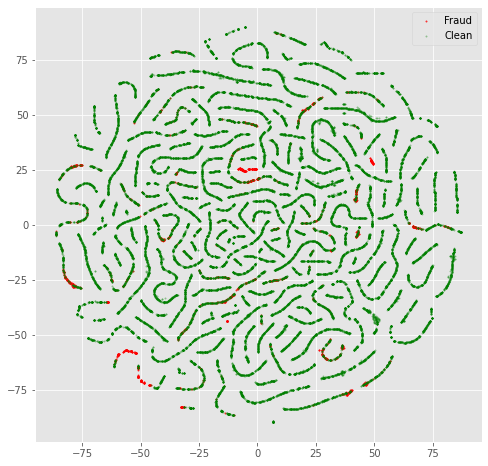

In [95]:
tsne_scatter(data, target, dimensions=2, save_as='tsne_initial_2d.png')

Anomalies aren't apparent

In [96]:
data=pd.concat([data,target],axis=1)

In [209]:
fraud = data[data.isAnomaly == 1]
clean = data[data.isAnomaly == 0]

In [210]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (37074, 235)
    fraud (rows, cols) = (1723, 235)


In [211]:
TRAINING_SAMPLE = 25952
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('isAnomaly', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [107]:
print(f"""Our testing set is composed as follows:

{X_test.isAnomaly.value_counts()}""")

Our testing set is composed as follows:

False    11122
True      1723
Name: isAnomaly, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate,y_train, y_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('isAnomaly', axis=1).values, X_test.isAnomaly.values

In [111]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (13286, 61)
    validate (rows, cols) = (3322, 61)
    holdout  (rows, cols) = (12845, 61)


In [112]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [113]:
pipeline.fit(X_train);

In [114]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


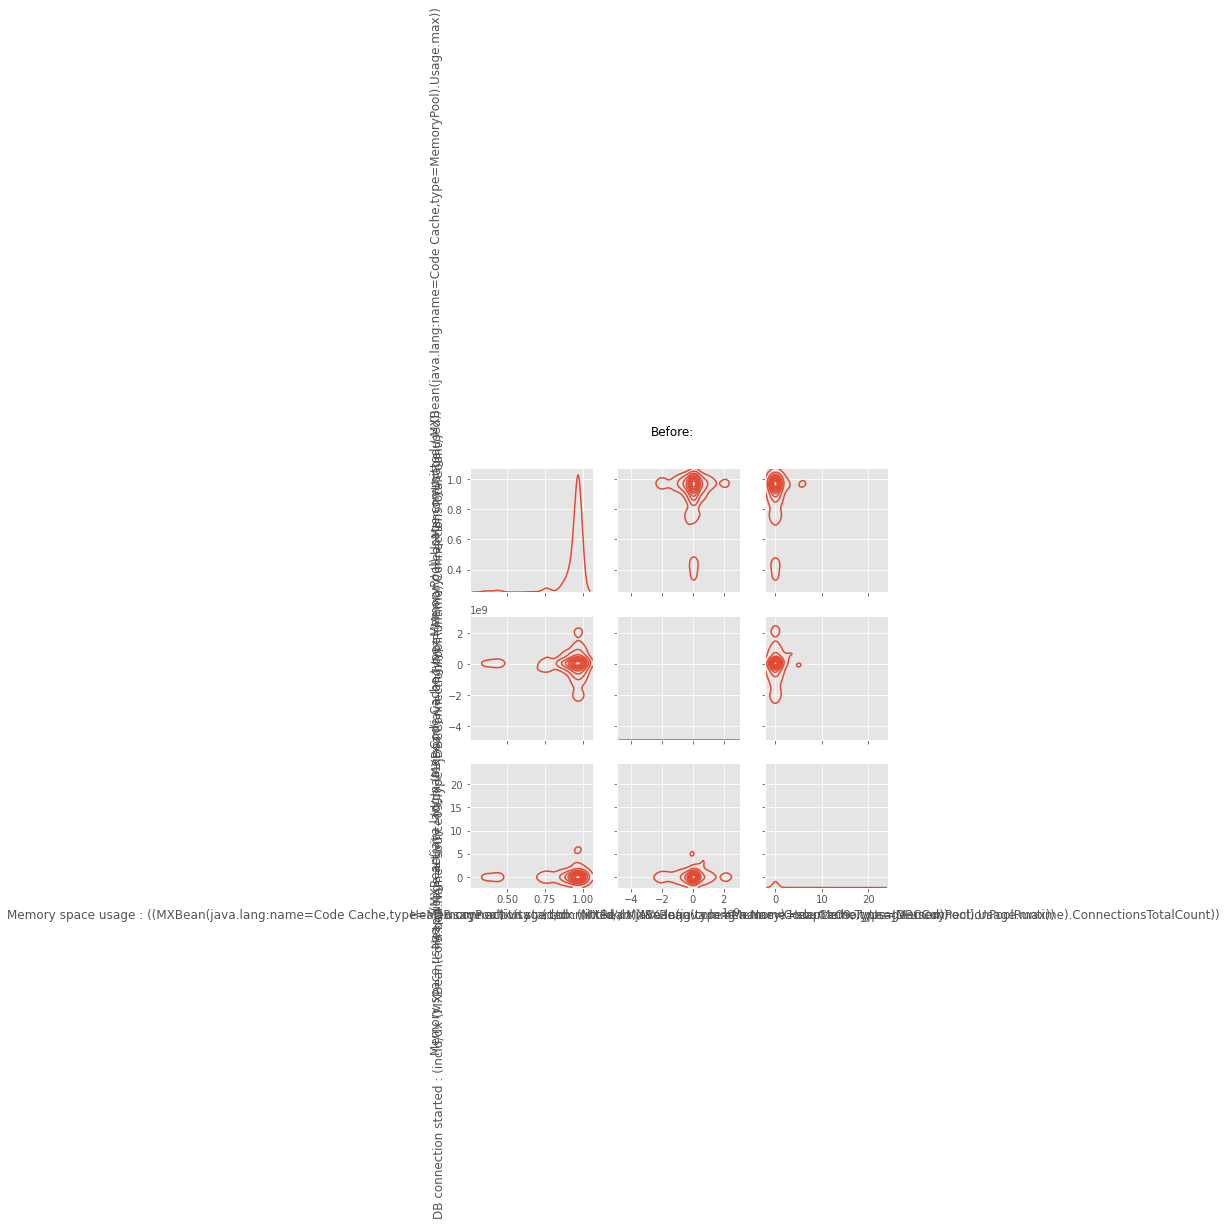

In [115]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

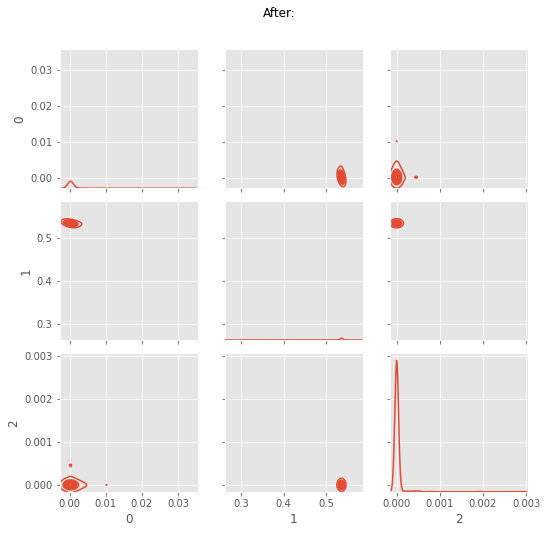

In [117]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

We can tell the data is slightly more uniform and proportionally distributed. 
The ranges were also shrunk to fit between 0 and 1.

In [118]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 61)                3782      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4

In [119]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [120]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
52/52 [==============================] - 2s 10ms/step - loss: 0.0835 - acc: 0.1496 - val_loss: 0.4373 - val_acc: 0.7730
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0034 - acc: 0.5322 - val_loss: 0.4194 - val_acc: 0.2261
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 1.2557e-04 - acc: 0.5955 - val_loss: 0.4193 - val_acc: 0.2213
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 1.1797e-04 - acc: 0.2503 - val_loss: 0.4191 - val_acc: 0.2207
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 1.1778e-04 - acc: 0.3443 - val_loss: 0.4190 - val_acc: 0.2188
Epoch 6/100
52/52 [==============================] - 0s 5ms/step - loss: 1.1769e-04 - acc: 0.3166 - val_loss: 0.4189 - val_acc: 0.8104
Epoch 7/100
52/52 [==============================] - 0s 4ms/step - loss: 1.1778e-04 - acc: 0.5162 - val_loss: 0.4188 - val_acc: 0.2255
Epoch 8/100
52/52 [==============================] - 0s 4ms/st

In [121]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

In [122]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed- reconstructions, 2), axis=1)

In [145]:
THRESHOLD = 3

def mad_score(points):
    
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [146]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} operations [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,431 outliers in a total of 12,845 operations [11.14%].


In [132]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [133]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[9696 1426]
 [1718    5]]

% of transactions labeled as fraud that were correct (precision): 5/(1426+5) = 0.35%
% of fraudulent transactions were caught succesfully (recall):    5/(1718+5) = 0.29%


In [139]:
# Accuracy
(9701/12845)*100

75.52355001946283

### FBProphet

In [ ]:
!pip install fbprophet
from fbprophet import Prophet
import os

In [204]:
# View the data as a table
df_ = pd.DataFrame(data, columns=['timestamp', r'Available db connection activity : (d/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumAvailable))'])
df_['ds']=df_['timestamp']
df_['y']=df_[r'Available db connection activity : (d/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumAvailable))'].astype(float)
df_=df_.drop(['timestamp',r'Available db connection activity : (d/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumAvailable))'],axis=1)
df_.head()

,ds,y
0,2015-02-04 04:27,0.0
1,2015-02-04 04:28,0.0
2,2015-02-04 04:29,-1.0
3,2015-02-04 04:30,0.0
4,2015-02-04 04:31,0.0


Displaying Prophet plot


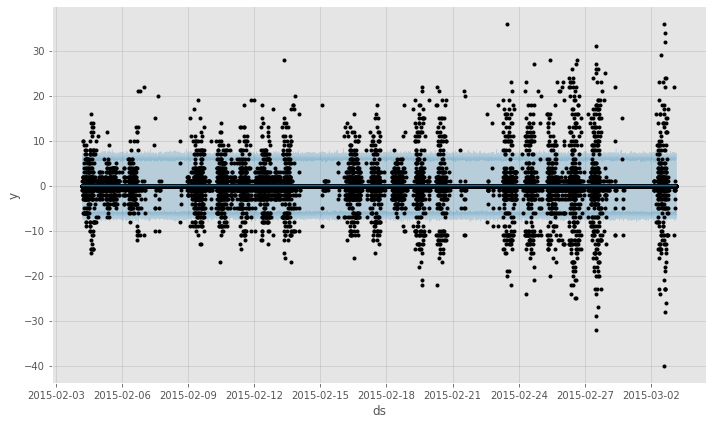

In [205]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
#                 seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(df_)

In [198]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1 #-1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [199]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2015-02-04 04:27:00,0.001585,0.001585,-6.690312,6.796649,0.0,0,0.0
1,2015-02-04 04:28:00,0.001584,0.001584,-6.526425,6.085810,0.0,0,0.0
2,2015-02-04 04:29:00,0.001584,0.001584,-6.083295,6.444107,-1.0,0,0.0
3,2015-02-04 04:30:00,0.001584,0.001584,-6.136835,6.603961,0.0,0,0.0
4,2015-02-04 04:31:00,0.001584,0.001584,-7.564240,6.413553,0.0,0,0.0


In [200]:
pred[ r'anomaly'].value_counts()

0    37436
1     1361
Name: anomaly, dtype: int64

In [201]:
#Accuracy
1361/1723

0.7899013348810214

### Supervised

In [ ]:
#Handling imbalance
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(data, target)

In [259]:
print(x_nm.shape,y_nm.shape)

(3446, 61) (3446,)


In [260]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
x_scaled = scalar.fit_transform(x_nm)

In [261]:
from sklearn.model_selection import train_test_split, cross_val_score
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y_nm, test_size = 0.25)

In [262]:
scores = {}
acc = []
cv_scores = []
def model(model):
    model.fit(x_train,y_train)
    score = model.score(x_test,y_test)
    print("Accuracy: {}".format(score))
    cv_score = cross_val_score(model,x_train,y_train,cv=5)
    print("Cross Val Score: {}".format(np.mean(cv_score)))
    acc.append(score)
    cv_scores.append(np.mean(cv_score))

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier()
model(clf)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
model(clf)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
model(clf)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
model(clf)
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
model(clf)
from sklearn.svm import SVC
clf = SVC()
model(clf)
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
model(clf)
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
model(clf)
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
model(clf)

In [272]:
models = ["XGBClassifier","LogisticRegression","RandomForestClassifier","DecisionTreeClassifier","KNeighborsClassifier","SVC","GaussianNB","AdaBoostClassifier","GradientBoostingClassifier"]
scores = { "Model Name" : models , "Accuracy Score" : acc, "Cross val Score": cv_scores}
df1 = pd.DataFrame(scores)

In [273]:
df1

,Model Name,Accuracy Score,Cross val Score
0,XGBClassifier,0.998840,0.996517
1,LogisticRegression,0.997680,0.990712
2,RandomForestClassifier,0.997680,0.994966
3,DecisionTreeClassifier,0.996520,0.991871
4,KNeighborsClassifier,0.991879,0.983358
5,SVC,0.993039,0.986453
6,GaussianNB,0.906032,0.904025
7,AdaBoostClassifier,1.000000,0.996904
8,GradientBoostingClassifier,0.998840,0.994968
